<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class05/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG From Scratch**

## Cifar10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters 
num_epochs = 10
batch_size = 64
learning_rate = 1e-4 #0.0001

In [ ]:
transform = transforms.Compose(
    [ transforms.Resize([224,224]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
iterator = iter(train_loader)
images,labels = next(iterator)
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [ ]:
def show(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

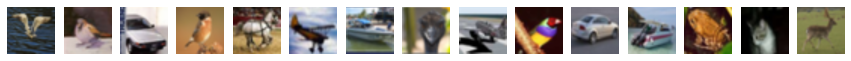

In [ ]:
fig, axes = plt.subplots(1,15, figsize=(15, 15))
for i in range(15):
  axes[i].imshow(show(images[i]))
  axes[i].set_axis_off()
fig.show()

## VGG from scratch

In [ ]:
VGG_types = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
class VGG(nn.Module):
    def __init__(self, mode, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types[mode])
        
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10),
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
                
        return nn.Sequential(*layers)

In [ ]:
vgg16 = VGG(mode='VGG16').to(device)

In [ ]:
print(vgg16)

VGG(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), str

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(vgg16)

27573834

In [ ]:
n_total_steps = len(train_loader)
for epoch in tqdm(range(num_epochs)):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 3, 224, 224]
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = vgg16(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/782], Loss: 1.7011
Epoch [1/10], Step [200/782], Loss: 1.7069
Epoch [1/10], Step [300/782], Loss: 1.4963
Epoch [1/10], Step [400/782], Loss: 1.3851
Epoch [1/10], Step [500/782], Loss: 1.4061
Epoch [1/10], Step [600/782], Loss: 1.1930
Epoch [1/10], Step [700/782], Loss: 1.0713


 10%|█         | 1/10 [06:35<59:20, 395.56s/it]

Epoch [2/10], Step [100/782], Loss: 0.9977
Epoch [2/10], Step [200/782], Loss: 1.1511
Epoch [2/10], Step [300/782], Loss: 0.9164
Epoch [2/10], Step [400/782], Loss: 0.8073
Epoch [2/10], Step [500/782], Loss: 1.0953
Epoch [2/10], Step [600/782], Loss: 0.5149
Epoch [2/10], Step [700/782], Loss: 0.8666


 20%|██        | 2/10 [13:04<52:12, 391.62s/it]

Epoch [3/10], Step [100/782], Loss: 0.8140
Epoch [3/10], Step [200/782], Loss: 1.0062
Epoch [3/10], Step [300/782], Loss: 0.5787
Epoch [3/10], Step [400/782], Loss: 0.8867
Epoch [3/10], Step [500/782], Loss: 0.6595
Epoch [3/10], Step [600/782], Loss: 1.0264
Epoch [3/10], Step [700/782], Loss: 0.6990


 30%|███       | 3/10 [19:33<45:32, 390.35s/it]

Epoch [4/10], Step [100/782], Loss: 0.6331
Epoch [4/10], Step [200/782], Loss: 0.8037
Epoch [4/10], Step [300/782], Loss: 0.6511
Epoch [4/10], Step [400/782], Loss: 0.7126
Epoch [4/10], Step [500/782], Loss: 0.7050
Epoch [4/10], Step [600/782], Loss: 0.7741
Epoch [4/10], Step [700/782], Loss: 0.5104


 40%|████      | 4/10 [26:02<38:58, 389.77s/it]

Epoch [5/10], Step [100/782], Loss: 0.5249
Epoch [5/10], Step [200/782], Loss: 0.5443
Epoch [5/10], Step [300/782], Loss: 0.6734
Epoch [5/10], Step [400/782], Loss: 0.5071
Epoch [5/10], Step [500/782], Loss: 0.5676
Epoch [5/10], Step [600/782], Loss: 0.7371
Epoch [5/10], Step [700/782], Loss: 0.5134


 50%|█████     | 5/10 [32:31<32:27, 389.49s/it]

Epoch [6/10], Step [100/782], Loss: 0.3389
Epoch [6/10], Step [200/782], Loss: 0.5925
Epoch [6/10], Step [300/782], Loss: 0.5780
Epoch [6/10], Step [400/782], Loss: 0.4244
Epoch [6/10], Step [500/782], Loss: 0.6236
Epoch [6/10], Step [600/782], Loss: 0.5249
Epoch [6/10], Step [700/782], Loss: 0.2388


 60%|██████    | 6/10 [39:00<25:57, 389.29s/it]

Epoch [7/10], Step [100/782], Loss: 0.4258
Epoch [7/10], Step [200/782], Loss: 0.3920
Epoch [7/10], Step [300/782], Loss: 0.4026
Epoch [7/10], Step [400/782], Loss: 0.3466
Epoch [7/10], Step [500/782], Loss: 0.4431
Epoch [7/10], Step [600/782], Loss: 0.4858
Epoch [7/10], Step [700/782], Loss: 0.5224


 70%|███████   | 7/10 [45:29<19:27, 389.21s/it]

Epoch [8/10], Step [100/782], Loss: 0.3090
Epoch [8/10], Step [200/782], Loss: 0.7025
Epoch [8/10], Step [300/782], Loss: 0.4189
Epoch [8/10], Step [400/782], Loss: 0.5153
Epoch [8/10], Step [500/782], Loss: 0.3018
Epoch [8/10], Step [600/782], Loss: 0.4212
Epoch [8/10], Step [700/782], Loss: 0.3397


 80%|████████  | 8/10 [51:58<12:58, 389.16s/it]

Epoch [9/10], Step [100/782], Loss: 0.2487
Epoch [9/10], Step [200/782], Loss: 0.3206
Epoch [9/10], Step [300/782], Loss: 0.1832
Epoch [9/10], Step [400/782], Loss: 0.2814
Epoch [9/10], Step [500/782], Loss: 0.2966
Epoch [9/10], Step [600/782], Loss: 0.2668
Epoch [9/10], Step [700/782], Loss: 0.4873


 90%|█████████ | 9/10 [58:27<06:29, 389.12s/it]

Epoch [10/10], Step [100/782], Loss: 0.2753
Epoch [10/10], Step [200/782], Loss: 0.2259
Epoch [10/10], Step [300/782], Loss: 0.2961
Epoch [10/10], Step [400/782], Loss: 0.5664
Epoch [10/10], Step [500/782], Loss: 0.2222
Epoch [10/10], Step [600/782], Loss: 0.3648
Epoch [10/10], Step [700/782], Loss: 0.6321


100%|██████████| 10/10 [1:04:56<00:00, 389.63s/it]


In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = vgg16(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 71.13 %
